# **Import Library**

In [25]:
import os, gc, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import torch.backends.cudnn as cudnn

from torchvision import transforms
from torchvision.datasets.folder import default_loader
import timm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# **Konfigurasi**

In [26]:
class CFG:
    base_dir  = "/kaggle/input/final-srifoton-25-machine-learning-competition"
    train_dir = os.path.join(base_dir, "train/train")
    test_dir  = os.path.join(base_dir, "test/test")

    model_name = "tf_efficientnet_b5_ns"
    img_size   = None
    batch_size = 8
    num_workers= 2
    epochs     = 5 # or 13
    lr         = 2e-4
    weight_decay = 1e-4
    seed       = 42
    
    n_splits = 3 # or 5

    label_map = {
        "COVID": 0,
        "Normal": 1,
        "Viral Pneumonia": 2
    }

In [27]:
# --- Seed & Device ---
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = False
    cudnn.benchmark = True

seed_everything(CFG.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# --- Resolve input size dari timm ---
def resolve_size_from_timm(model_name: str):
    tmp = timm.create_model(model_name, pretrained=True)
    sz = tmp.default_cfg.get("input_size", (3,224,224))[1]
    del tmp; gc.collect()
    return sz

if CFG.img_size is None:
    CFG.img_size = resolve_size_from_timm(CFG.model_name)
print(f"Input size: {CFG.img_size}")

Device: cuda
Input size: 456


# **Transformasi**

In [28]:
train_tfms = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# **Train Data**

In [29]:
train_data = []
for cls in os.listdir(CFG.train_dir):
    folder = os.path.join(CFG.train_dir, cls)
    if not os.path.isdir(folder): continue
    for f in os.listdir(folder):
        train_data.append([os.path.join(folder,f), CFG.label_map[cls]])
train_df = pd.DataFrame(train_data, columns=["path","label"])

# **Pseudo-Label**

In [30]:
pseudo_df = pd.read_csv("/kaggle/input/pseudo-label/pseudo_labels.csv")
pseudo_df["path"] = pseudo_df["ID"].astype(str) + ".png"  # sesuaikan ekstensi jika perlu
pseudo_df["path"] = pseudo_df["path"].apply(lambda x: os.path.join(CFG.test_dir, x))
pseudo_df = pseudo_df[["path","Predicted"]].rename(columns={"Predicted":"label"})

# Gabung dataset + pseudo
combined_df = pd.concat([train_df, pseudo_df], ignore_index=True)
print("Total data (train+pseudo):", len(combined_df))

# --- Dataset Custom ---
class CustomDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        img = default_loader(self.df.loc[i,"path"])
        img = self.tfms(img)
        label = int(self.df.loc[i,"label"])
        return img, label

full_dataset = CustomDataset(combined_df, train_tfms)
targets = combined_df["label"].values
class_names = list(CFG.label_map.keys())

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)

Total data (train+pseudo): 14510


# **MODEL**

In [31]:
def build_model(model_name: str, num_classes: int):
    return timm.create_model(model_name, pretrained=True, num_classes=num_classes)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average="macro")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0)
    return f1, report, y_true, y_pred

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for x,y in tqdm(loader, leave=False, desc="Training"):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
    return running_loss/len(loader.sampler)

# **Cross Validation Training**

## **Cost-sensitive loss**

In [32]:
oof_scores = []
oof_y_true = []
oof_y_pred = []

for fold,(train_idx,val_idx) in enumerate(skf.split(np.arange(len(full_dataset)), targets)):
    print(f"\n========== FOLD {fold+1}/{CFG.n_splits} ==========")
    
    val_labels = targets[val_idx].tolist()
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler   = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(full_dataset, batch_size=CFG.batch_size, sampler=train_sampler, num_workers=CFG.num_workers, pin_memory=True)
    val_loader   = DataLoader(full_dataset, batch_size=CFG.batch_size, sampler=val_sampler, num_workers=CFG.num_workers, pin_memory=True)
    
    val_loader.dataset.tfms = val_tfms
    
    model = build_model(CFG.model_name, num_classes=len(class_names)).to(device)
    train_labels = targets[train_idx]
    counts = np.bincount(train_labels, minlength=len(class_names))
    class_weights = 1.0 / np.clip(counts, 1, None)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.epochs)
    
    best_f1_fold = -1
    best_preds_fold = []

    for epoch in range(1, CFG.epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_f1, val_report, _, epoch_preds = evaluate(model, val_loader)
        scheduler.step()
        
        print(f"\nEpoch {epoch}/{CFG.epochs} | TrainLoss: {tr_loss:.4f} | Val F1: {val_f1:.4f}")
        
        if val_f1 > best_f1_fold:
            best_f1_fold = val_f1
            best_preds_fold = epoch_preds
            torch.save(model.state_dict(), f"best_model_fold_{fold}.pth")
            print(f"✅ Best model for fold {fold} saved with F1: {best_f1_fold:.4f}")
            print(val_report)

    val_loader.dataset.tfms = train_tfms
            
    oof_scores.append(best_f1_fold)
    oof_y_true.extend(val_labels)
    oof_y_pred.extend(best_preds_fold)

    del model, train_loader, val_loader
    gc.collect()

print(f"\nCV finished. OOF Macro F1 scores: {oof_scores}")
print(f"Mean OOF Macro F1: {np.mean(oof_scores):.4f} | Std: {np.std(oof_scores):.4f}")


========== FOLD 1/3 ==========


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(



Epoch 1/5 | TrainLoss: 0.2000 | Val F1: 0.9763
✅ Best model for fold 0 saved with F1: 0.9763
                 precision    recall  f1-score   support

          COVID     0.9783    0.9774    0.9778      1105
         Normal     0.9960    0.9867    0.9913      3300
Viral Pneumonia     0.9267    0.9954    0.9598       432

       accuracy                         0.9853      4837
      macro avg     0.9670    0.9865    0.9763      4837
   weighted avg     0.9858    0.9853    0.9854      4837




Epoch 2/5 | TrainLoss: 0.0566 | Val F1: 0.9927
✅ Best model for fold 0 saved with F1: 0.9927
                 precision    recall  f1-score   support

          COVID     0.9910    0.9955    0.9932      1105
         Normal     0.9982    0.9948    0.9965      3300
Viral Pneumonia     0.9817    0.9954    0.9885       432

       accuracy                         0.9950      4837
      macro avg     0.9903    0.9952    0.9927      4837
   weighted avg     0.9951    0.9950    0.9950      4837




Epoch 3/5 | TrainLoss: 0.0171 | Val F1: 0.9919



Epoch 4/5 | TrainLoss: 0.0135 | Val F1: 0.9881



Epoch 5/5 | TrainLoss: 0.0039 | Val F1: 0.9968
✅ Best model for fold 0 saved with F1: 0.9968
                 precision    recall  f1-score   support

          COVID     0.9973    0.9973    0.9973      1105
         Normal     0.9988    0.9991    0.9989      3300
Viral Pneumonia     0.9954    0.9931    0.9942       432

       accuracy                         0.9981      4837
      macro avg     0.9971    0.9965    0.9968      4837
   weighted avg     0.9981    0.9981    0.9981      4837


========== FOLD 2/3 ==========


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(



Epoch 1/5 | TrainLoss: 0.2249 | Val F1: 0.9777
✅ Best model for fold 1 saved with F1: 0.9777
                 precision    recall  f1-score   support

          COVID     0.9640    0.9928    0.9782      1105
         Normal     0.9963    0.9815    0.9889      3299
Viral Pneumonia     0.9488    0.9838    0.9660       433

       accuracy                         0.9843      4837
      macro avg     0.9697    0.9860    0.9777      4837
   weighted avg     0.9847    0.9843    0.9844      4837




Epoch 2/5 | TrainLoss: 0.0581 | Val F1: 0.9887
✅ Best model for fold 1 saved with F1: 0.9887
                 precision    recall  f1-score   support

          COVID     0.9883    0.9946    0.9914      1105
         Normal     0.9979    0.9927    0.9953      3299
Viral Pneumonia     0.9684    0.9908    0.9795       433

       accuracy                         0.9930      4837
      macro avg     0.9849    0.9927    0.9887      4837
   weighted avg     0.9930    0.9930    0.9930      4837




Epoch 3/5 | TrainLoss: 0.0151 | Val F1: 0.9746



Epoch 4/5 | TrainLoss: 0.0256 | Val F1: 0.9873



Epoch 5/5 | TrainLoss: 0.0068 | Val F1: 0.9929
✅ Best model for fold 1 saved with F1: 0.9929
                 precision    recall  f1-score   support

          COVID     0.9964    0.9964    0.9964      1105
         Normal     0.9988    0.9955    0.9971      3299
Viral Pneumonia     0.9730    0.9977    0.9852       433

       accuracy                         0.9959      4837
      macro avg     0.9894    0.9965    0.9929      4837
   weighted avg     0.9959    0.9959    0.9959      4837


========== FOLD 3/3 ==========


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(



Epoch 1/5 | TrainLoss: 0.2025 | Val F1: 0.9667
✅ Best model for fold 2 saved with F1: 0.9667
                 precision    recall  f1-score   support

          COVID     0.9017    0.9973    0.9471      1104
         Normal     0.9972    0.9600    0.9782      3299
Viral Pneumonia     0.9681    0.9815    0.9748       433

       accuracy                         0.9704      4836
      macro avg     0.9557    0.9796    0.9667      4836
   weighted avg     0.9728    0.9704    0.9708      4836




Epoch 2/5 | TrainLoss: 0.0462 | Val F1: 0.9893
✅ Best model for fold 2 saved with F1: 0.9893
                 precision    recall  f1-score   support

          COVID     0.9955    0.9928    0.9941      1104
         Normal     0.9952    0.9964    0.9958      3299
Viral Pneumonia     0.9792    0.9769    0.9780       433

       accuracy                         0.9938      4836
      macro avg     0.9899    0.9887    0.9893      4836
   weighted avg     0.9938    0.9938    0.9938      4836




Epoch 3/5 | TrainLoss: 0.0216 | Val F1: 0.9880



Epoch 4/5 | TrainLoss: 0.0136 | Val F1: 0.9948
✅ Best model for fold 2 saved with F1: 0.9948
                 precision    recall  f1-score   support

          COVID     0.9964    0.9982    0.9973      1104
         Normal     0.9970    0.9985    0.9977      3299
Viral Pneumonia     0.9977    0.9815    0.9895       433

       accuracy                         0.9969      4836
      macro avg     0.9970    0.9927    0.9948      4836
   weighted avg     0.9969    0.9969    0.9969      4836




Epoch 5/5 | TrainLoss: 0.0011 | Val F1: 0.9957
✅ Best model for fold 2 saved with F1: 0.9957
                 precision    recall  f1-score   support

          COVID     0.9982    0.9982    0.9982      1104
         Normal     0.9976    0.9988    0.9982      3299
Viral Pneumonia     0.9953    0.9861    0.9907       433

       accuracy                         0.9975      4836
      macro avg     0.9970    0.9944    0.9957      4836
   weighted avg     0.9975    0.9975    0.9975      4836


CV finished. OOF Macro F1 scores: [0.9968102932428063, 0.9928907866569497, 0.995696677438934]
Mean OOF Macro F1: 0.9951 | Std: 0.0016


# **OOF EVALUATION**


--- Out-of-Fold (OOF) Evaluation ---
OOF Classification Report:
                 precision    recall  f1-score   support

          COVID     0.2170    0.2170    0.2170      3314
         Normal     0.6781    0.6777    0.6779      9898
Viral Pneumonia     0.0844    0.0847    0.0846      1298

       accuracy                         0.5194     14510
      macro avg     0.3265    0.3265    0.3265     14510
   weighted avg     0.5197    0.5194    0.5196     14510



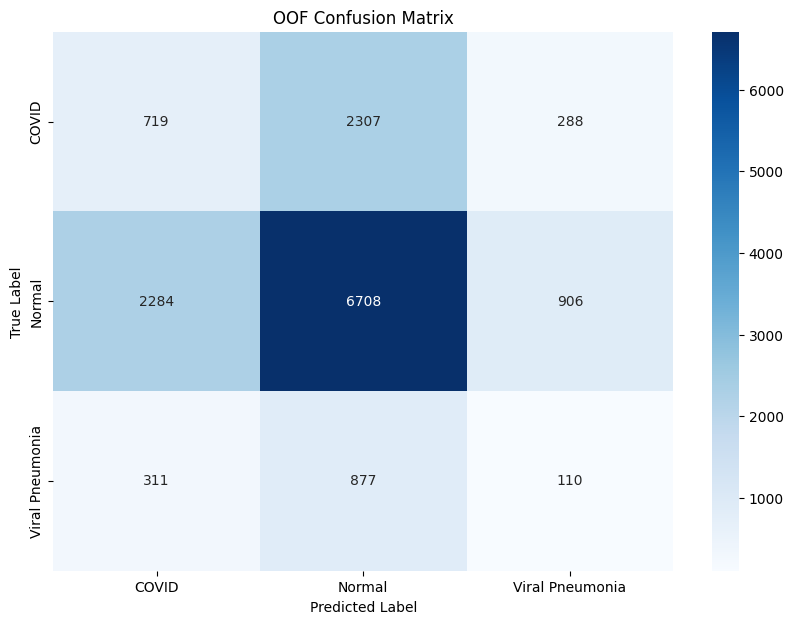

In [33]:
print("\n--- Out-of-Fold (OOF) Evaluation ---")
print("OOF Classification Report:")
print(classification_report(oof_y_true, oof_y_pred, target_names=class_names, digits=4, zero_division=0))

cm = confusion_matrix(oof_y_true, oof_y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('OOF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Ensemble Inference**

In [35]:
print("\nStarting inference with ensembled models...")

models = []
for fold in range(CFG.n_splits):
    model = build_model(CFG.model_name, len(class_names)).to(device)
    model.load_state_dict(torch.load(f"best_model_fold_{fold}.pth"))
    model.eval()
    models.append(model)

test_images = sorted([f for f in os.listdir(CFG.test_dir) if f.lower().endswith((".jpeg", ".jpg", ".png"))])
results = []

with torch.no_grad():
    for img_name in tqdm(test_images, desc="Inference"):
        path = os.path.join(CFG.test_dir, img_name)
        img = default_loader(path)
        x = val_tfms(img).unsqueeze(0).to(device)
        
        all_probs = []
        for model in models:
            logits = model(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            all_probs.append(probs)
        
        avg_probs = np.mean(all_probs, axis=0)
        final_pred_idx = np.argmax(avg_probs)

        class_name = class_names[final_pred_idx]
        comp_id = CFG.label_map[class_name]
        base_name, _ = os.path.splitext(img_name)
        
        results.append([base_name, comp_id])

submission = pd.DataFrame(results, columns=["ID", "Predicted"])
submission_filename = "submission_effnetb5_5fold_pseudo_cost.csv"
submission.to_csv(submission_filename, index=False)
print(f"🎉 {submission_filename} saved with {len(submission)} rows")


Starting inference with ensembled models...


Inference: 100%|██████████| 6382/6382 [07:39<00:00, 13.90it/s]

🎉 submission_effnetb5_5fold_pseudo_cost.csv saved with 6382 rows
